# PEAK3 Modelling

## Initialisation

In [3]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import * 

import matplotlib.pyplot as plt
import roadrunner
import numpy as np
import pandas as pd

## Basic Model between 14-3-3 and Grb2

In [2]:
model = ModelBuilder('PEAK3_Simple_1')
model.add_reaction(Reaction(mass_action_21, ('PEAK3', 'Grb2'), ('PEAK3_Grb2',)))
model.add_reaction(Reaction(mass_action_21, ('PEAK3', 'Four'), ('PEAK3_Four',)))
model.precompile()


In [ ]:
print(model.get_antimony_model())

In [ ]:
model.simulate(0, 100, 100)
model.plot()

In [ ]:
sbml = model.get_sbml_model()
rr = roadrunner.RoadRunner(sbml)

states = model.get_all_variables_keys()
custom_states = model.get_custom_variable_keys()
sim_states = ['time'] + states
res = rr.simulate(0, 180, 180, selections=sim_states)

### VISUALISATION

observable_states = ['PEAK3', 'PEAK3_Four', 'Four']

for state in observable_states:
    plt.plot(res['time'], res[f'{state}'], label=state)

plt.legend()
plt.grid()
plt.show()


observable_states_2 = ['PEAK3', 'Grb2', 'PEAK3_Grb2']

for state in observable_states_2:
    plt.plot(res['time'], res[f'{state}'], label=state)
    
plt.legend()
plt.grid()
plt.show()

## Replication of Honours Model 2020

### Direct SBML Import from TXTBC File 

In [ ]:
# load sbml file from the path: src\models\examples\peak3\peak3-honours-sbml.xml without using ModelBuilder

rr = roadrunner.RoadRunner('C:\Github\\new-peak-project\src\models\examples\peak3\peak3-honours-sbml-older.xml')

# simulate the model

sim_data = rr.simulate(0, 5000 + 60 * 24, 180)
# visualise the named array 

# plt.plot(sim_data[0], sim_data[2], label='PEAK3')

print(sim_data.colnames)

for state in sim_data.colnames:
    if state == 'time':
        continue
    plt.plot(sim_data['time'], sim_data[state], label=state)
    
# only plot the later part of the simulation
plt.xlim(5000, 5000 + 60 * 24)
# plt.legend()
plt.grid()
plt.show()


In [100]:
# load in parameter set from a txt file 
# C:\Github\new-peak-project\src\models\examples\peak3\Finalparamset-NoFix.txt

# param_set = pd.read_csv('C:\Github\\new-peak-project\src\models\examples\peak3\Finalparamset-NoFix.txt', sep='\t', header=None)

# open txt file 

# all_param_sets_processed = []

# with open('C:\Github\\new-peak-project\src\models\examples\peak3\Finalparamset-NoFix.txt') as f:
#     lines = f.readlines()
#     all_param_set = [line.split('\t') for line in lines]
#     for param_set in all_param_set:
#         # remove the \n character 
#         # print(param_set)
#         param_set_real = param_set[0]
#         param_set_real = param_set_real.replace('\n', '')
        
#         param_set_individual = param_set_real.split('   ')
#         # remove the first element
#         param_set_individual.pop(0)
#         # print(param_set_individual)
#         # convert each element to float
#         param_set_individual = [float(i) for i in param_set_individual]
#         # remove the 17th element
#         param_set_individual.pop(16)
#         # print(param_set_individual)
#         # print(len(param_set_individual))    
#         all_param_sets_processed.append(param_set_individual)

# param_sets_df = pd.DataFrame(all_param_sets_processed)
        
    
# print(param_set)

In [ ]:
all_param_sets_processed = []

with open('C:\Github\\new-peak-project\src\models\examples\peak3\Finalparamset.txt') as f:
    lines = f.readlines()
    all_param_set = [line.split('\t') for line in lines]
    for param_set in all_param_set:
        # remove the \n character 
        # print(param_set)
        param_set_real = param_set[0]
        param_set_real = param_set_real.replace('\n', '')
        
        param_set_individual = param_set_real.split('   ')
        # remove the first five elements
        param_set_individual = param_set_individual[5:]
        # print(param_set_individual)
        # convert each element to float
        param_set_individual = [float(i) for i in param_set_individual]
        # remove the 17th element
        # print(param_set_individual)
        # print(len(param_set_individual))   
        # break 
        all_param_sets_processed.append(param_set_individual)

param_sets_df = pd.DataFrame(all_param_sets_processed)

In [ ]:
# get parameter names from the sbml file

param_names = rr.model.getGlobalParameterIds()

altered_params = param_names[:65]

print(altered_params)
# print(len(first_72_params))

# print(len(param_names))

In [ ]:
# get the first row from the param_sets_df

first_param_set = param_sets_df.iloc[4]

for i, param in enumerate(first_param_set):
    rr.model[altered_params[i]] = param
    
# check if the parameters have been set correctly

for i, param in enumerate(first_param_set):
    print(rr.model[altered_params[i]])
    
# simulate the model with the new parameters

sim_data = rr.simulate(0, 5000 + 60 * 24, 5000 + 50 * 24)

for state in sim_data.colnames:
    if state == 'time':
        continue
    plt.plot(sim_data['time'], sim_data[state], label=state)
    
# only plot the later part of the simulation
# plt.xlim(5000, 5000 + 60 * 24)
# plt.legend()
plt.grid()
plt.show()

In [ ]:
# extra values 

assignment_states = ['boundASAP1', 'boundGrb2']

# Convert to Pandas DataFrame
df = pd.DataFrame(sim_data, columns=sim_data.colnames)

# Get assignment rule names (parameters that are computed dynamically)
assignment_names = rr.getAssignmentRuleIds()

print("Assignment Rules Found:", assignment_names)

# Extract assignment values dynamically at each time step
assignment_values = {name: [] for name in assignment_names}

# Evaluate assignment rules at each time step
for i in range(len(df)):
    rr.time = df["time"][i]  # Set RoadRunner time
    for name in assignment_names:
        assignment_values[name].append(rr.getValue(name))  # Get computed assignment value

# Convert assignment data to DataFrame
df_assignments = pd.DataFrame(assignment_values, index=df["time"])

# Plot assignment rule values over time
plt.figure(figsize=(10, 6))
for col in df_assignments.columns:
    plt.plot(df_assignments.index, df_assignments[col], label=col)

plt.xlabel("Time")
plt.ylabel("Assignment Value")
plt.title("Assignment Rule Values Over Time")
# only plot the later part of the simulation
plt.xlim(5000, 5000 + 60 * 3)
# plt.legend()
plt.grid()
plt.show()

## Simplified Honours Model SFK/Grb2/ASAP1 Axis

Model Name PEAK3_Grb2_ASAP1
Number of Reactions 10
Number of State Variables 18
Number of Parameters 21
Number of Custom Variables 7
Number of Enforced State Values 18
Number of Custom Strings 0

-------------------

model PEAK3_Grb2_ASAP1

J0: pEGFR -> EGFR; J0_Vmax*pEGFR/(J0_Km + pEGFR)
J1: EGFR -> pEGFR; J1_Vmax*EGFR*egf/(J1_Km + EGFR)
J2: aSFK -> SFK; J2_Vmax*aSFK/(J2_Km + aSFK)
J3: SFK -> aSFK; J3_Vmax*SFK*pEGFR/(J3_Km + SFK)
core1: pdPEAK3 -> PEAK3; core1_Vmax*pdPEAK3/(core1_Km + pdPEAK3)
core1b: PEAK3 -> pdPEAK3; core1b_Vmax*PEAK3*(aSFK*core1b_Ka0)/(core1b_Km + PEAK3)
J6: pdPEAK3 + Grb2 -> pdPEAK3_Grb2; J6_ka*pdPEAK3*Grb2
J6r: pdPEAK3_Grb2 -> pdPEAK3 + Grb2; J6_kd*pdPEAK3_Grb2
J7: Grb2 + ASAP1 -> Grb2_ASAP1; J7_ka*Grb2*ASAP1
J7r: Grb2_ASAP1 -> Grb2 + ASAP1; J7_kd*Grb2_ASAP1
J8: pdPEAK3_Grb2 + ASAP1 -> pdPEAK3_Grb2_ASAP1; J8_ka*pdPEAK3_Grb2*ASAP1
J8r: pdPEAK3_Grb2_ASAP1 -> pdPEAK3_Grb2 + ASAP1; J8_kd*pdPEAK3_Grb2_ASAP1
J9: pdPEAK3 + Grb2_ASAP1 -> pdPEAK3_Grb2_ASAP1; J9_ka*pdPEAK3

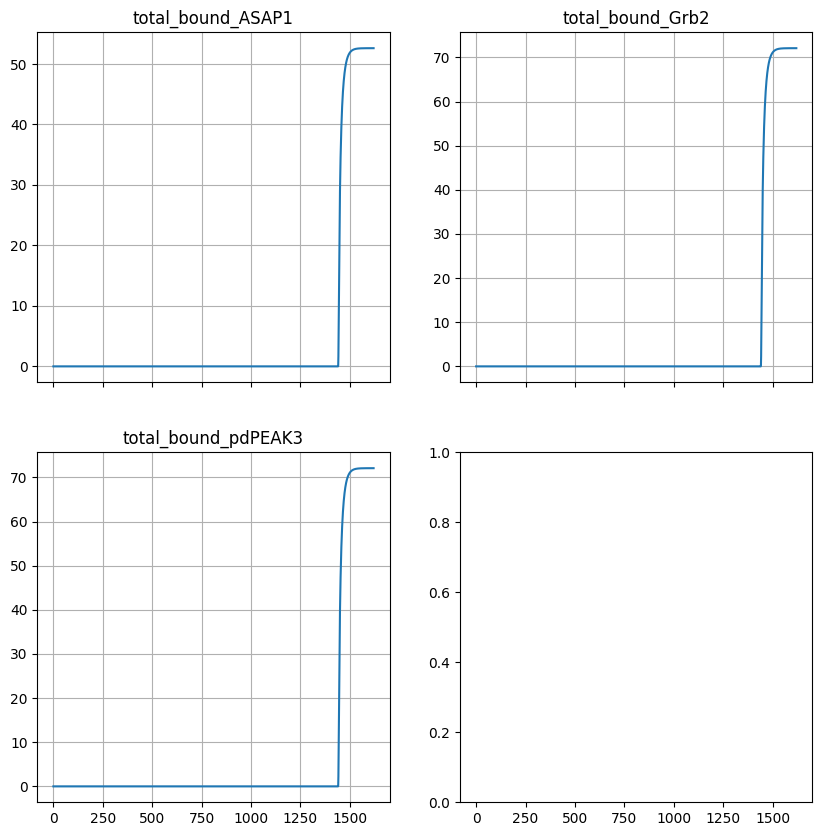

In [27]:
peak3_model = ModelBuilder('PEAK3_Grb2_ASAP1')

# Upstream EGF signalling

weak_stim = create_archtype_michaelis_menten(stimulator_weak=1)
normal_stim = create_archtype_michaelis_menten(stimulators=1)

# EGFR <-> pEGFR
peak3_model.add_reaction(Reaction(michaelis_menten, ('pEGFR',), ('EGFR',),zero_init=True))
peak3_model.add_reaction(Reaction(michaelis_menten_stim, ('EGFR',), ('pEGFR',), extra_states=('egf',), zero_init=True))

# SFK <-> aSFK
peak3_model.add_reaction(Reaction(michaelis_menten, ('aSFK',), ('SFK',), zero_init=True))
peak3_model.add_reaction(Reaction(michaelis_menten_stim, ('SFK',), ('aSFK',), extra_states=('pEGFR',), zero_init=True))

# PEAK3 <-> pPEAK3
peak3_model.add_reaction(Reaction(michaelis_menten, ('pdPEAK3',), ('PEAK3',), 'core1', zero_init=True))
peak3_model.add_reaction(Reaction(normal_stim, ('PEAK3',), ('pdPEAK3',), 'core1b', extra_states=('aSFK',),zero_init=True))

## Mass Action Reactions

# pdPEAK3 + Grb2 <-> pdPEAK3_Grb2
peak3_model.add_reaction(Reaction(mass_action_21, ('pdPEAK3', 'Grb2'), ('pdPEAK3_Grb2',)))

# Grb2 + ASAP1 <-> Grb2_ASAP1
peak3_model.add_reaction(Reaction(mass_action_21, ('Grb2', 'ASAP1'), ('Grb2_ASAP1',)))

# pdPEAK3_Grb2 + ASAP1 <-> pdPEAK3_Grb2_ASAP1
peak3_model.add_reaction(Reaction(mass_action_21, ('pdPEAK3_Grb2', 'ASAP1'), ('pdPEAK3_Grb2_ASAP1',)))

# pdPEAK3 + Grb2_ASAP1 <-> pdPEAK3_Grb2_ASAP1
peak3_model.add_reaction(Reaction(mass_action_21, ('pdPEAK3', 'Grb2_ASAP1'), ('pdPEAK3_Grb2_ASAP1',)))


peak3_model.add_simple_piecewise(0,1440.1,8.33,'egf')
peak3_model.add_custom_variables('total_bound_ASAP1', 'total_bound_ASAP1 := pdPEAK3_Grb2_ASAP1')
peak3_model.add_custom_variables('total_bound_Grb2', 'total_bound_Grb2 := pdPEAK3_Grb2 + pdPEAK3_Grb2_ASAP1')
peak3_model.add_custom_variables('total_bound_pdPEAK3', 'total_bound_pdPEAK3 := pdPEAK3_Grb2 + pdPEAK3_Grb2_ASAP1')
peak3_model.add_custom_variables('total_ASAP1', 'total_ASAP1 := ASAP1 + Grb2_ASAP1 + pdPEAK3_Grb2_ASAP1')
peak3_model.add_custom_variables('total_Grb2', 'total_Grb2 := Grb2 + Grb2_ASAP1 + pdPEAK3_Grb2 + pdPEAK3_Grb2_ASAP1')
peak3_model.add_custom_variables('total_pdPEAK3', 'total_pdPEAK3 := pdPEAK3 + pdPEAK3_Grb2 + pdPEAK3_Grb2_ASAP1')

init_species = ['EGFR', 'SFK', 'PEAK3', 'Grb2', 'ASAP1']

for s in init_species:
    peak3_model.add_enforce_state_value(s, 100)
    
# ensure the rest of the species are set to 0
remaining_species = [s for s in peak3_model.get_all_variables_keys() if s not in init_species]
for s in remaining_species:
    peak3_model.add_enforce_state_value(s, 0)
    
peak3_model.precompile()

print(peak3_model.head())

print('-------------------\n')

print(peak3_model.get_antimony_model())

### Edit Model Parameters

peak3_model.set_parameter('core1b_Vmax', 100)

### FINISHED MODEL CONSTRUCTION, BEGIN TEST SIMULATION

sbml = peak3_model.get_sbml_model()
rr = roadrunner.RoadRunner(sbml)

states = peak3_model.get_all_variables_keys()
custom_states = peak3_model.get_custom_variable_keys()
sim_states = ['time'] + states
res = rr.simulate(0, 1440+180, 1440+180, selections=sim_states)

### VISUALISATION

states_no_egf = [s for s in states if s != 'egf']
custom_states = peak3_model.get_custom_variable_keys()
custom_states = custom_states[1:4]
print(custom_states)

# create a multi-plot figure showing each custom state over time
cols = 2 # number of columns in the plot
rows = len(custom_states) // cols + 1 if len(custom_states) // 2 != 0 else len(custom_states) // 2
fig, axs = plt.subplots(rows, cols, figsize=(10, 10), sharex=True)

for i, state in enumerate(custom_states):
    ax = axs[i // cols, i % cols]
    ax.plot(res['time'], res[state])
    ax.set_title(state)
    ax.set_xlim(1440, 1440+180)
    ax.grid()
    


plt.show()